# Count of rides for the next month.


In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import timedelta

import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load data

In [440]:
server = 'mohamedibrahim'
database = 'railway_dwh'

connection_string = (
    f'mssql+pyodbc://mohamedibrahim/railway_dwh'
    '?driver=ODBC+Driver+17+for+SQL+Server'
    '&Trusted_Connection=yes'
)
engine = create_engine(connection_string)

query = """
SELECT dd.full_date, month, day, COUNT(transaction_id) AS Rides_Count
FROM gold.fact_railway f
JOIN gold.dim_date dd ON f.journey_date_id = dd.date_id
GROUP BY dd.full_date, month, day
ORDER BY dd.full_date
"""
df = pd.read_sql(query, engine)

# Preprocessing & Feature engineering

In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   full_date    121 non-null    object
 1   month        121 non-null    int64 
 2   day          121 non-null    int64 
 3   Rides_Count  121 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 3.9+ KB


In [442]:
df.head()

,full_date,month,day,Rides_Count
0,2024-01-01,1,1,66
1,2024-01-02,1,2,146
2,2024-01-03,1,3,292
3,2024-01-04,1,4,274
4,2024-01-05,1,5,253


In [443]:
df['full_date'] = pd.to_datetime(df['full_date'])

In [444]:
df.set_index('full_date', inplace=True)

In [445]:
df['day_of_week'] = df.index.dayofweek

In [446]:
import holidays


uk_holidays = holidays.UnitedKingdom(subdiv='ENG', years=2024, observed=True)
df['is_holiday'] = df.index.map(lambda x: x in uk_holidays)


In [447]:
df['is_holiday'] = df['is_holiday'].astype(int)


In [448]:
df['lag_1'] = df['Rides_Count'].shift(1)
df['lag_7'] = df['Rides_Count'].shift(7)
df['lag_14'] = df['Rides_Count'].shift(14)


In [449]:
df[['lag_1', 'lag_7', 'lag_14']] = df[['lag_1', 'lag_7', 'lag_14']].fillna(0)

# Forecasting

## Prepare Train & Test data

In [452]:
train = df.loc[df.index < '2024-04-11']
test = df.loc[df.index >= '2024-04-11']

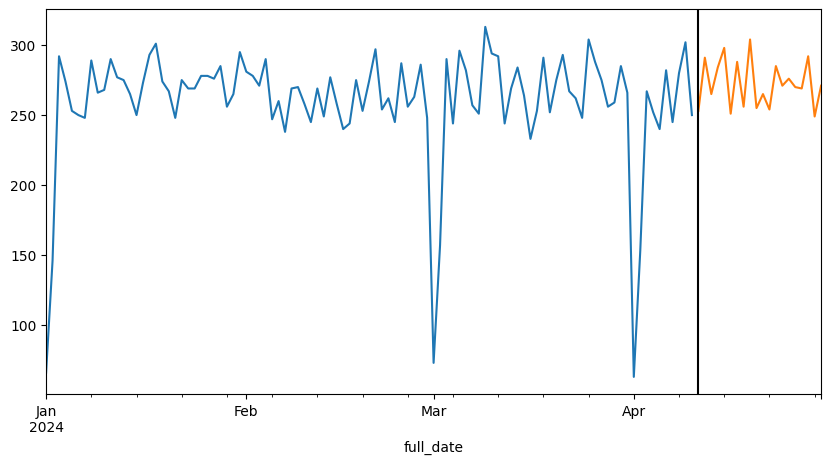

In [453]:
fig, ax = plt.subplots(figsize=(10,5))
train['Rides_Count'].plot(ax=ax,label='tarining set')
test['Rides_Count'].plot(ax=ax,label='test set')
ax.axvline('2024-04-11', color='black')
plt.show()


## Creat model

In [454]:
# define the features
features = ['month', 'day', 'day_of_week', 'is_holiday','lag_1', 'lag_7', 'lag_14']

In [455]:
# prepare the training data
x_train = train[features]
y_train = train['Rides_Count']

x_test = test[features]
y_test = test['Rides_Count']

In [ ]:

# train XGBOOST model
model = xg.XGBRegressor(
    n_estimators=100,
    learning_rate = 0.2,
    max_depth=3,
    random_state=42,
    early_stopping_rounds=20  

)

model.fit(
    x_train, 
    y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True
)



[0]	validation_0-rmse:36.88293	validation_1-rmse:20.16125
[1]	validation_0-rmse:32.28936	validation_1-rmse:19.25457
[2]	validation_0-rmse:28.46340	validation_1-rmse:18.20880
[3]	validation_0-rmse:25.35674	validation_1-rmse:17.80884
[4]	validation_0-rmse:22.78851	validation_1-rmse:17.39136
[5]	validation_0-rmse:20.72822	validation_1-rmse:16.77217
[6]	validation_0-rmse:19.04930	validation_1-rmse:16.60109
[7]	validation_0-rmse:17.69422	validation_1-rmse:16.30347
[8]	validation_0-rmse:16.64583	validation_1-rmse:16.23252
[9]	validation_0-rmse:15.75102	validation_1-rmse:16.35045
[10]	validation_0-rmse:14.95156	validation_1-rmse:16.15574
[11]	validation_0-rmse:14.46266	validation_1-rmse:16.22691
[12]	validation_0-rmse:13.93571	validation_1-rmse:15.91444
[13]	validation_0-rmse:13.57266	validation_1-rmse:15.98617
[14]	validation_0-rmse:13.24524	validation_1-rmse:15.85565
[15]	validation_0-rmse:12.84951	validation_1-rmse:15.61806
[16]	validation_0-rmse:12.59760	validation_1-rmse:15.71329
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

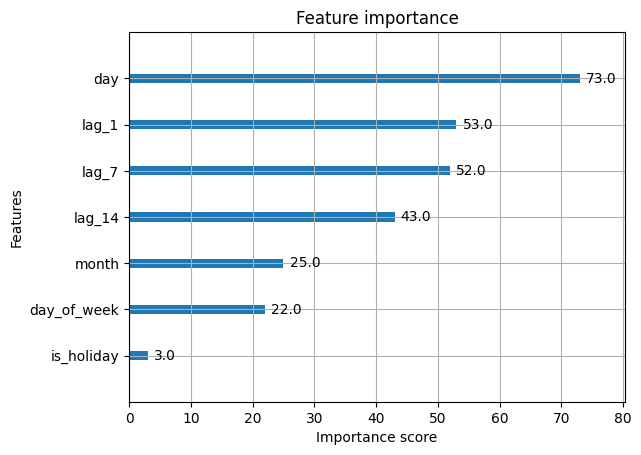

In [699]:
xg.plot_importance(model)
plt.show()


In [700]:
# Make predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)


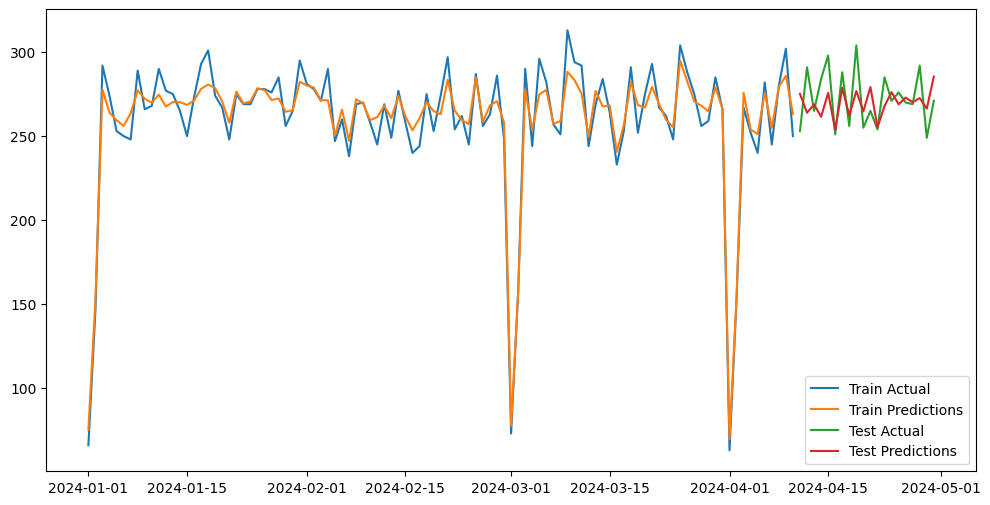

In [701]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label='Train Actual')
plt.plot(train.index, train_preds, label='Train Predictions')
plt.plot(test.index, y_test, label='Test Actual')
plt.plot(test.index, test_preds, label='Test Predictions')
plt.legend()
plt.show()


## Forecasting the Next Month

In [702]:
# Create a dataframe for the next month
last_date = df.index.max()
next_month_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)
future_df = pd.DataFrame(index=next_month_dates)


In [703]:

future_df['day_of_week'] = future_df.index.dayofweek
future_df['month'] = future_df.index.month
future_df['day'] = future_df.index.day
future_df['is_holiday'] = future_df.index.map(lambda x: x in uk_holidays).astype(int)


In [704]:
# Copy original dataframe to append predictions for lag calculation
history = df.copy()

# Placeholder for predictions
predictions = []


In [705]:

# Forecast each day one by one 
for date in future_df.index:
    row = {}
    row['month'] = date.month
    row['day'] = date.day
    row['day_of_week'] = date.dayofweek
    row['is_holiday'] = int(date in uk_holidays)
    row['lag_1'] = history['Rides_Count'].iloc[-1]
    row['lag_7'] = history['Rides_Count'].iloc[-7] if len(history) >= 7 else 0
    row['lag_14'] = history['Rides_Count'].iloc[-14] if len(history) >= 14 else 0

    # Predict
    features_row = pd.DataFrame([row])
    pred = model.predict(features_row)[0]

    # Store prediction
    predictions.append(pred)

    # Append to history to update lags for next iteration
    history = pd.concat([
        history,
        pd.DataFrame({'Rides_Count': [pred]}, index=[date])
    ])


In [706]:

# Assign predictions to future_df
future_df['predicted_Rides_Count'] = predictions

# Results

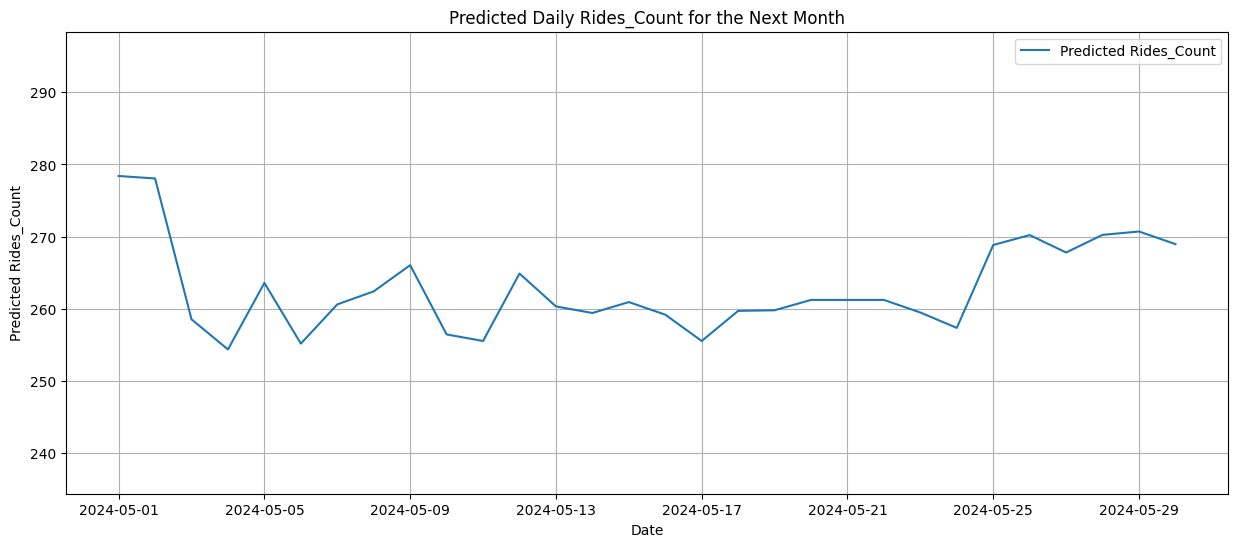


Predicted Daily Rides_Count for the Next Month:
2024-05-01    278.404633
2024-05-02    278.062134
2024-05-03    258.538940
2024-05-04    254.364532
2024-05-05    263.586426
2024-05-06    255.170837
2024-05-07    260.606842
2024-05-08    262.413300
2024-05-09    266.044464
2024-05-10    256.446259
2024-05-11    255.534927
2024-05-12    264.886932
2024-05-13    260.326965
2024-05-14    259.415619
2024-05-15    260.930786
2024-05-16    259.184174
2024-05-17    255.534927
2024-05-18    259.710815
2024-05-19    259.792938
2024-05-20    261.229919
2024-05-21    261.229919
2024-05-22    261.229919
2024-05-23    259.483307
2024-05-24    257.349213
2024-05-25    268.843109
2024-05-26    270.216187
2024-05-27    267.801117
2024-05-28    270.249634
2024-05-29    270.711365
2024-05-30    268.964752
Freq: D, Name: predicted_Rides_Count, dtype: float32


,day_of_week,month,day,is_holiday,predicted_Rides_Count
2024-05-01,2,5,1,0,278.404633
2024-05-02,3,5,2,0,278.062134
2024-05-03,4,5,3,0,258.538940
2024-05-04,5,5,4,0,254.364532
2024-05-05,6,5,5,0,263.586426
2024-05-06,0,5,6,1,255.170837
2024-05-07,1,5,7,0,260.606842
2024-05-08,2,5,8,0,262.413300
2024-05-09,3,5,9,0,266.044464
2024-05-10,4,5,10,0,256.446259


In [712]:

# Plot forecasted Rides_Count
plt.figure(figsize=(15, 6))
plt.plot(future_df.index, future_df['predicted_Rides_Count'], label='Predicted Rides_Count')
plt.title('Predicted Daily Rides_Count for the Next Month')
plt.xlabel('Date')
plt.ylabel('Predicted Rides_Count')
# Set y-axis to a larger range to observe variation better
# Corrected: Set y-axis to a larger range
plt.ylim(future_df['predicted_Rides_Count'].min() - 20, 
         future_df['predicted_Rides_Count'].max() + 20)
plt.legend()
plt.grid(True)
plt.show()

# Print forecasted values
print("\nPredicted Daily Rides_Count for the Next Month:")
print(future_df['predicted_Rides_Count'])
future_df